# 뉴스 기사 요약

In [29]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas
import pandas as pd
from tqdm import tqdm
import numpy as np

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## 1. 데이터 수집

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
print(data.shape)
data.head()

(98401, 2)


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 2. 데이터 전처리

In [8]:
text, headlines = "text", "headlines"

In [9]:
# 중복 데이터 확인

print('text :', data[text].nunique())
print('headline :', data[headlines].nunique())

text : 98360
headline : 98280


In [10]:
# 중복 데이터 제거

data.drop_duplicates(subset=text, inplace=True)
print("전체 샘플 수", len(data))

전체 샘플 수 98360


In [11]:
# 결측치 확인

data.isnull().sum() 

headlines    0
text         0
dtype: int64

In [12]:
# 사전 정의 정규화 사전

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                   "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                   "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                   "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                   "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                   "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                   "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                   "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                   "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                   "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                   "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                   "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                   "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                   "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                   "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                   "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                   "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                   "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                   "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [18]:
# 불용어 데이터

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

print('불용어 개수 :', len(stopwords.words('english') ))

불용어 개수 : 179


In [22]:
# 데이터 전처리 함수

from bs4 import BeautifulSoup
import re

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [27]:
# 텍스트 전처리 적용

clean_text, clean_summary = [], []
for _, rows in tqdm(data.iterrows(), desc="inprogress"):
    clean_text.append(preprocess_sentence(rows[text]))
    clean_summary.append(preprocess_sentence(rows[headlines], False))

inprogress: 98360it [10:14, 159.95it/s]


In [30]:
# 전처리 후 데이터 재 확인

data[text] = clean_text
data[headlines] = clean_summary

print(data.isnull().sum())
data.replace("", np.nan, inplace=True)
print(data.isnull().sum())

headlines    0
text         0
dtype: int64
headlines    0
text         0
dtype: int64


In [31]:
# 최종 데이터 수

print(len(data))

98360


In [33]:
# 텍스트 길이 분포 출력

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data[text]]
summary_len = [len(s.split()) for s in data[headlines]]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


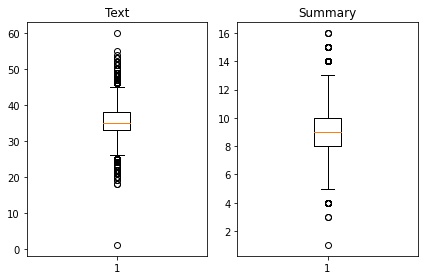

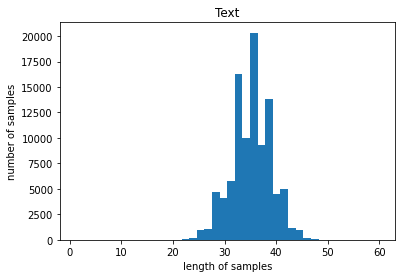

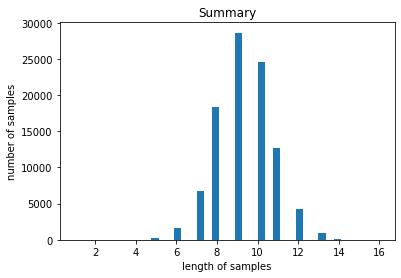

In [34]:
# 분포 시각화

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
# max 길이 설정

text_max_len = 60
summary_max_len = 16

In [37]:
# 설정 길이에 대한 샘플 비율 확인

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data[text])
below_threshold_len(summary_max_len, data[headlines])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [38]:
# 정해진 길이보다 길 경우 제거

is_less_max = data.apply(lambda row: len(row[text].split()) <= text_max_len, 
                         axis="columns")
print("max 길이 이하 샘플 수", is_less_max.sum())

max 길이 이하 샘플 수 98360


In [39]:
#전체 샘플 수 출력

data = data[is_less_max]
print("전체 샘플 수", len(data))

전체 샘플 수 98360


In [40]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가

data['decoder_input'] = data[headlines].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data[headlines].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [51]:
# encoder, decoder input 데이터 

encoder_input = np.array(data[text]) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

train test 분리

In [52]:
# 인덱스 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 랜덤 인덱싱
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 테스트 데이터셋 계산
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

[96976 74727 19179 ...  6950 74057 48072]
테스트 데이터의 수 : 19672


In [53]:
# train, test 인덱싱

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


단어 집합 생성

In [45]:
# 토크나이징

from tensorflow.keras.preprocessing.text import Tokenizer

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

빈도 수가 낮은 데이터 확인

In [47]:
# threshold를 정해 빈도 수가 낮은 단어 확인

threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69618
등장 빈도가 6번 이하인 희귀 단어의 수: 47460
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22158
단어 집합에서 희귀 단어의 비율: 68.1720244764285
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4838164331688155


In [48]:
# 빈도수가 낮은 단어 제거

src_vocab = 22_000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [54]:
# 텍스트를 정수 시퀀스로 변환

from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [55]:
# headline를 정수 시퀀스로 변환

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [56]:
# headline 단어 빈도 수 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30062
등장 빈도가 5번 이하인 희귀 단어의 수: 19608
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10454
단어 집합에서 희귀 단어의 비율: 65.22520125074846
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.62786194777196


In [57]:
# 적은 빈도 수 단어 제거

tar_vocab = 10_400
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [58]:
# 정수 시퀀스로 변환

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [59]:
# 단어 처리 후 텍스트 데이터 길이 확인, decoder input 이 1인 데이터 제거

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [60]:
# 최종 텍스트 패딩

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 3. 어텐션 메커니즘 사용

1) 인코더 설계

In [65]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# Embedding
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True , dropout=0.4) # recurrent_dropout=0.4
encoder_output1, _, _ = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True , dropout=0.4) # recurrent_dropout=0.4
encoder_output2, _, _ = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True , dropout=0.4) # recurrent_dropout=0.4
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm2(encoder_output2)

2) 디코더 설계

In [66]:
decoder_inputs = Input(shape=(None,))

# Embedding
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[encoder_state_h, encoder_state_c])

# 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 128)      2816000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 60, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

3) 어텐션

In [68]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name="attention_layer")

attn_out = attn_layer([encoder_output, decoder_outputs]) # query - value - value / https://shorturl.at/srHPQ

decoder_concat_input = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation="softmax")
decoder_softmax_output = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 128)      2816000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 60, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

4) 모델 훈련

In [69]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="rmsprop")

es = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

X_train, y_train = [encoder_input_train, decoder_input_train], decoder_target_train
X_valid, y_valid = [encoder_input_test, decoder_input_test], decoder_target_test

history = model.fit(x=X_train, y=y_train,
          validation_data=(X_valid, y_valid),
          batch_size=256, epochs=50, callbacks=[es])

Epoch 1/50
308/308 [==============================] - 37s 99ms/step - loss: 4.3943 - val_loss: 4.0949
Epoch 2/50
308/308 [==============================] - 30s 98ms/step - loss: 4.0267 - val_loss: 3.9098
Epoch 3/50
308/308 [==============================] - 30s 97ms/step - loss: 3.8414 - val_loss: 3.7207
Epoch 4/50
308/308 [==============================] - 30s 97ms/step - loss: 3.6295 - val_loss: 3.5593
Epoch 5/50
308/308 [==============================] - 30s 97ms/step - loss: 3.4653 - val_loss: 3.4291
Epoch 6/50
308/308 [==============================] - 30s 97ms/step - loss: 3.3315 - val_loss: 3.3308
Epoch 7/50
308/308 [==============================] - 30s 97ms/step - loss: 3.2196 - val_loss: 3.2403
Epoch 8/50
308/308 [==============================] - 30s 97ms/step - loss: 3.1217 - val_loss: 3.1721
Epoch 9/50
308/308 [==============================] - 30s 97ms/step - loss: 3.0362 - val_loss: 3.1184
Epoch 10/50
308/308 [==============================] - 30s 97ms/step - loss: 2.958

5) 훈련 내용 시각화

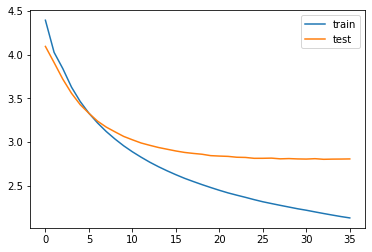

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

6) 추론 모델 구현

In [72]:
# word index

src_index_to_word = src_tokenizer.index_word # 원문
tar_word_to_index = tar_tokenizer.word_index # 헤드라인
tar_index_to_word = tar_tokenizer.index_word # 헤드라인

In [73]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output, encoder_state_h, encoder_state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [74]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [75]:
# 디코더 출력 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 실제 결과와 비교

- 모델 테스트

In [95]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq[1:-1]:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

for i in range(51, 53):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : two startups namely printed electric car lakh claimed takes three days make car top speed kmph travel km single charge components car printed except seats glass 
실제 요약 : birth led five four state affect added saying us startup 
예측 요약 :  charles charles charles charles eggs kurdish rjd songs insecure insecure insecure must ecb must soldiers


원문 : microsoft pledged million next five years ai earth program company announced program announced july make ai accessible researchers solve environmental challenges microsoft also provide universities organisations advanced training put ai best use microsoft president brad smith said 
실제 요약 : process communication using year platform us getting links 
예측 요약 :  bsf bsf agrees ysr leads lapse defender pl sperm uniforms jahan uniforms uniforms intervenes sad




## 5. Summa를 이용해 추출적 요약

In [132]:
# import library

from summa.summarizer import summarize
from summa import keywords

1) ratio 기준

In [134]:
for i in range(51, 53):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(text=seq2text(encoder_input_test[i]), ratio=0.1, split=True))
    print("키워드: ", keywords.keywords(seq2text(encoder_input_test[i]), split=True))
    print("\n")

원문 : two startups namely printed electric car lakh claimed takes three days make car top speed kmph travel km single charge components car printed except seats glass 
실제 요약 : birth led five four state affect added saying us startup 
예측 요약 : []
키워드:  ['car', 'kmph', 'claimed']


원문 : microsoft pledged million next five years ai earth program company announced program announced july make ai accessible researchers solve environmental challenges microsoft also provide universities organisations advanced training put ai best use microsoft president brad smith said 
실제 요약 : process communication using year platform us getting links 
예측 요약 : []
키워드:  ['ai', 'microsoft', 'advanced', 'universities', 'announced']




2) word 기준

In [135]:
for i in range(51, 53):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(text=seq2text(encoder_input_test[i]), words=50, split=True))
    print("키워드: ", keywords.keywords(seq2text(encoder_input_test[i]), split=True))
    print("\n")

원문 : two startups namely printed electric car lakh claimed takes three days make car top speed kmph travel km single charge components car printed except seats glass 
실제 요약 : birth led five four state affect added saying us startup 
예측 요약 : []
키워드:  ['car', 'kmph', 'claimed']


원문 : microsoft pledged million next five years ai earth program company announced program announced july make ai accessible researchers solve environmental challenges microsoft also provide universities organisations advanced training put ai best use microsoft president brad smith said 
실제 요약 : process communication using year platform us getting links 
예측 요약 : []
키워드:  ['ai', 'microsoft', 'advanced', 'universities', 'announced']




## 회고

* 배운 점
  - Keras Attention과 LSTM을 이용해 요약 seq2seq 모델을 구현하는 방법을 학습했다.
* 아쉬운 점
  - 학습시에 시간이 오래걸려서 더 많이 시도해볼 시간이 부족해서 아쉬웠다.
* 느낀 점
  - 언어 모델의 구조에 대해서 더 깊이있게 이해하고 파악하면 재미있을 것 같다.
* 어려웠던 점
  - 추론 모델을 설계하는 부분이 한 번에 이해되지 않아서 어려웠다. 